In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})

In [3]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [4]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    # dmdt = p**2/(kc4**2 + p**2) - kc5 * m
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [5]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 0.01 # Using 0.1 for nutlin seems to make it a lot more smooth than using 0?? Is this okay?

y0 = [p0, m0, Mf0, Mb0, n0]

In [6]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='LSODA', max_step = 0.5, dense_output = True)

In [7]:
time_transient, p_transient, m_transient, Mf_transient, Mb_transient, n_transient = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

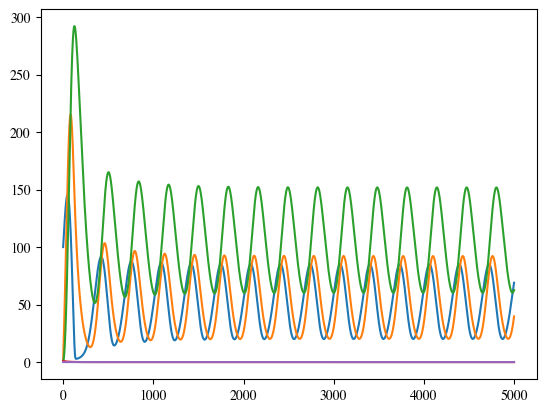

In [8]:
plt.plot(time_transient, p_transient)
plt.plot(time_transient, m_transient)
plt.plot(time_transient, Mf_transient)
plt.plot(time_transient, Mb_transient)
plt.plot(time_transient, n_transient)

In [9]:
# Compute stats for p53 transient to find period and amplitude for nutlin simulation
def compute_external_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [10]:
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_external_oscillator(time_transient, p_transient)

In [11]:
print(T_int, A_int)

330.25 32.41543730275253


# Simulér med nutlin

In [12]:
def sim_onoff_nutlin(oscillationer, T_int, OOmega, p0, m0, Mf0, Mb0, A_ext):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    # TODO: Undersøg max_step i fremtiden
    for i in range(oscillationer):
        if i == 0:
            state = p0, m0, Mf0, Mb0, A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Every period, Nutlin concentration is reset to A_ext
        state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
        t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["p"].extend(p)
        history["m"].extend(m)
        history["Mf"].extend(Mf)
        history["Mb"].extend(Mb)
        history["n"].extend(n)
    
    return history, omega, T_ext

In [13]:
current_omega = 0.5
coupling_strength =0.8
Nutlin_A = A_int*coupling_strength

In [14]:
nutlin_sim1, omega, T_ext_sim1 = sim_onoff_nutlin(400, T_int, current_omega, p_transient[-1], m_transient[-1], Mf_transient[-1], Mb_transient[-1], Nutlin_A)

In [15]:
t_1, p_1, m_1, Mb_1, Mf_1, n_1 = np.array(nutlin_sim1["t"]), np.array(nutlin_sim1["p"]), np.array(nutlin_sim1["m"]), np.array(nutlin_sim1["Mb"]), np.array(nutlin_sim1["Mf"]), np.array(nutlin_sim1["n"])

[]

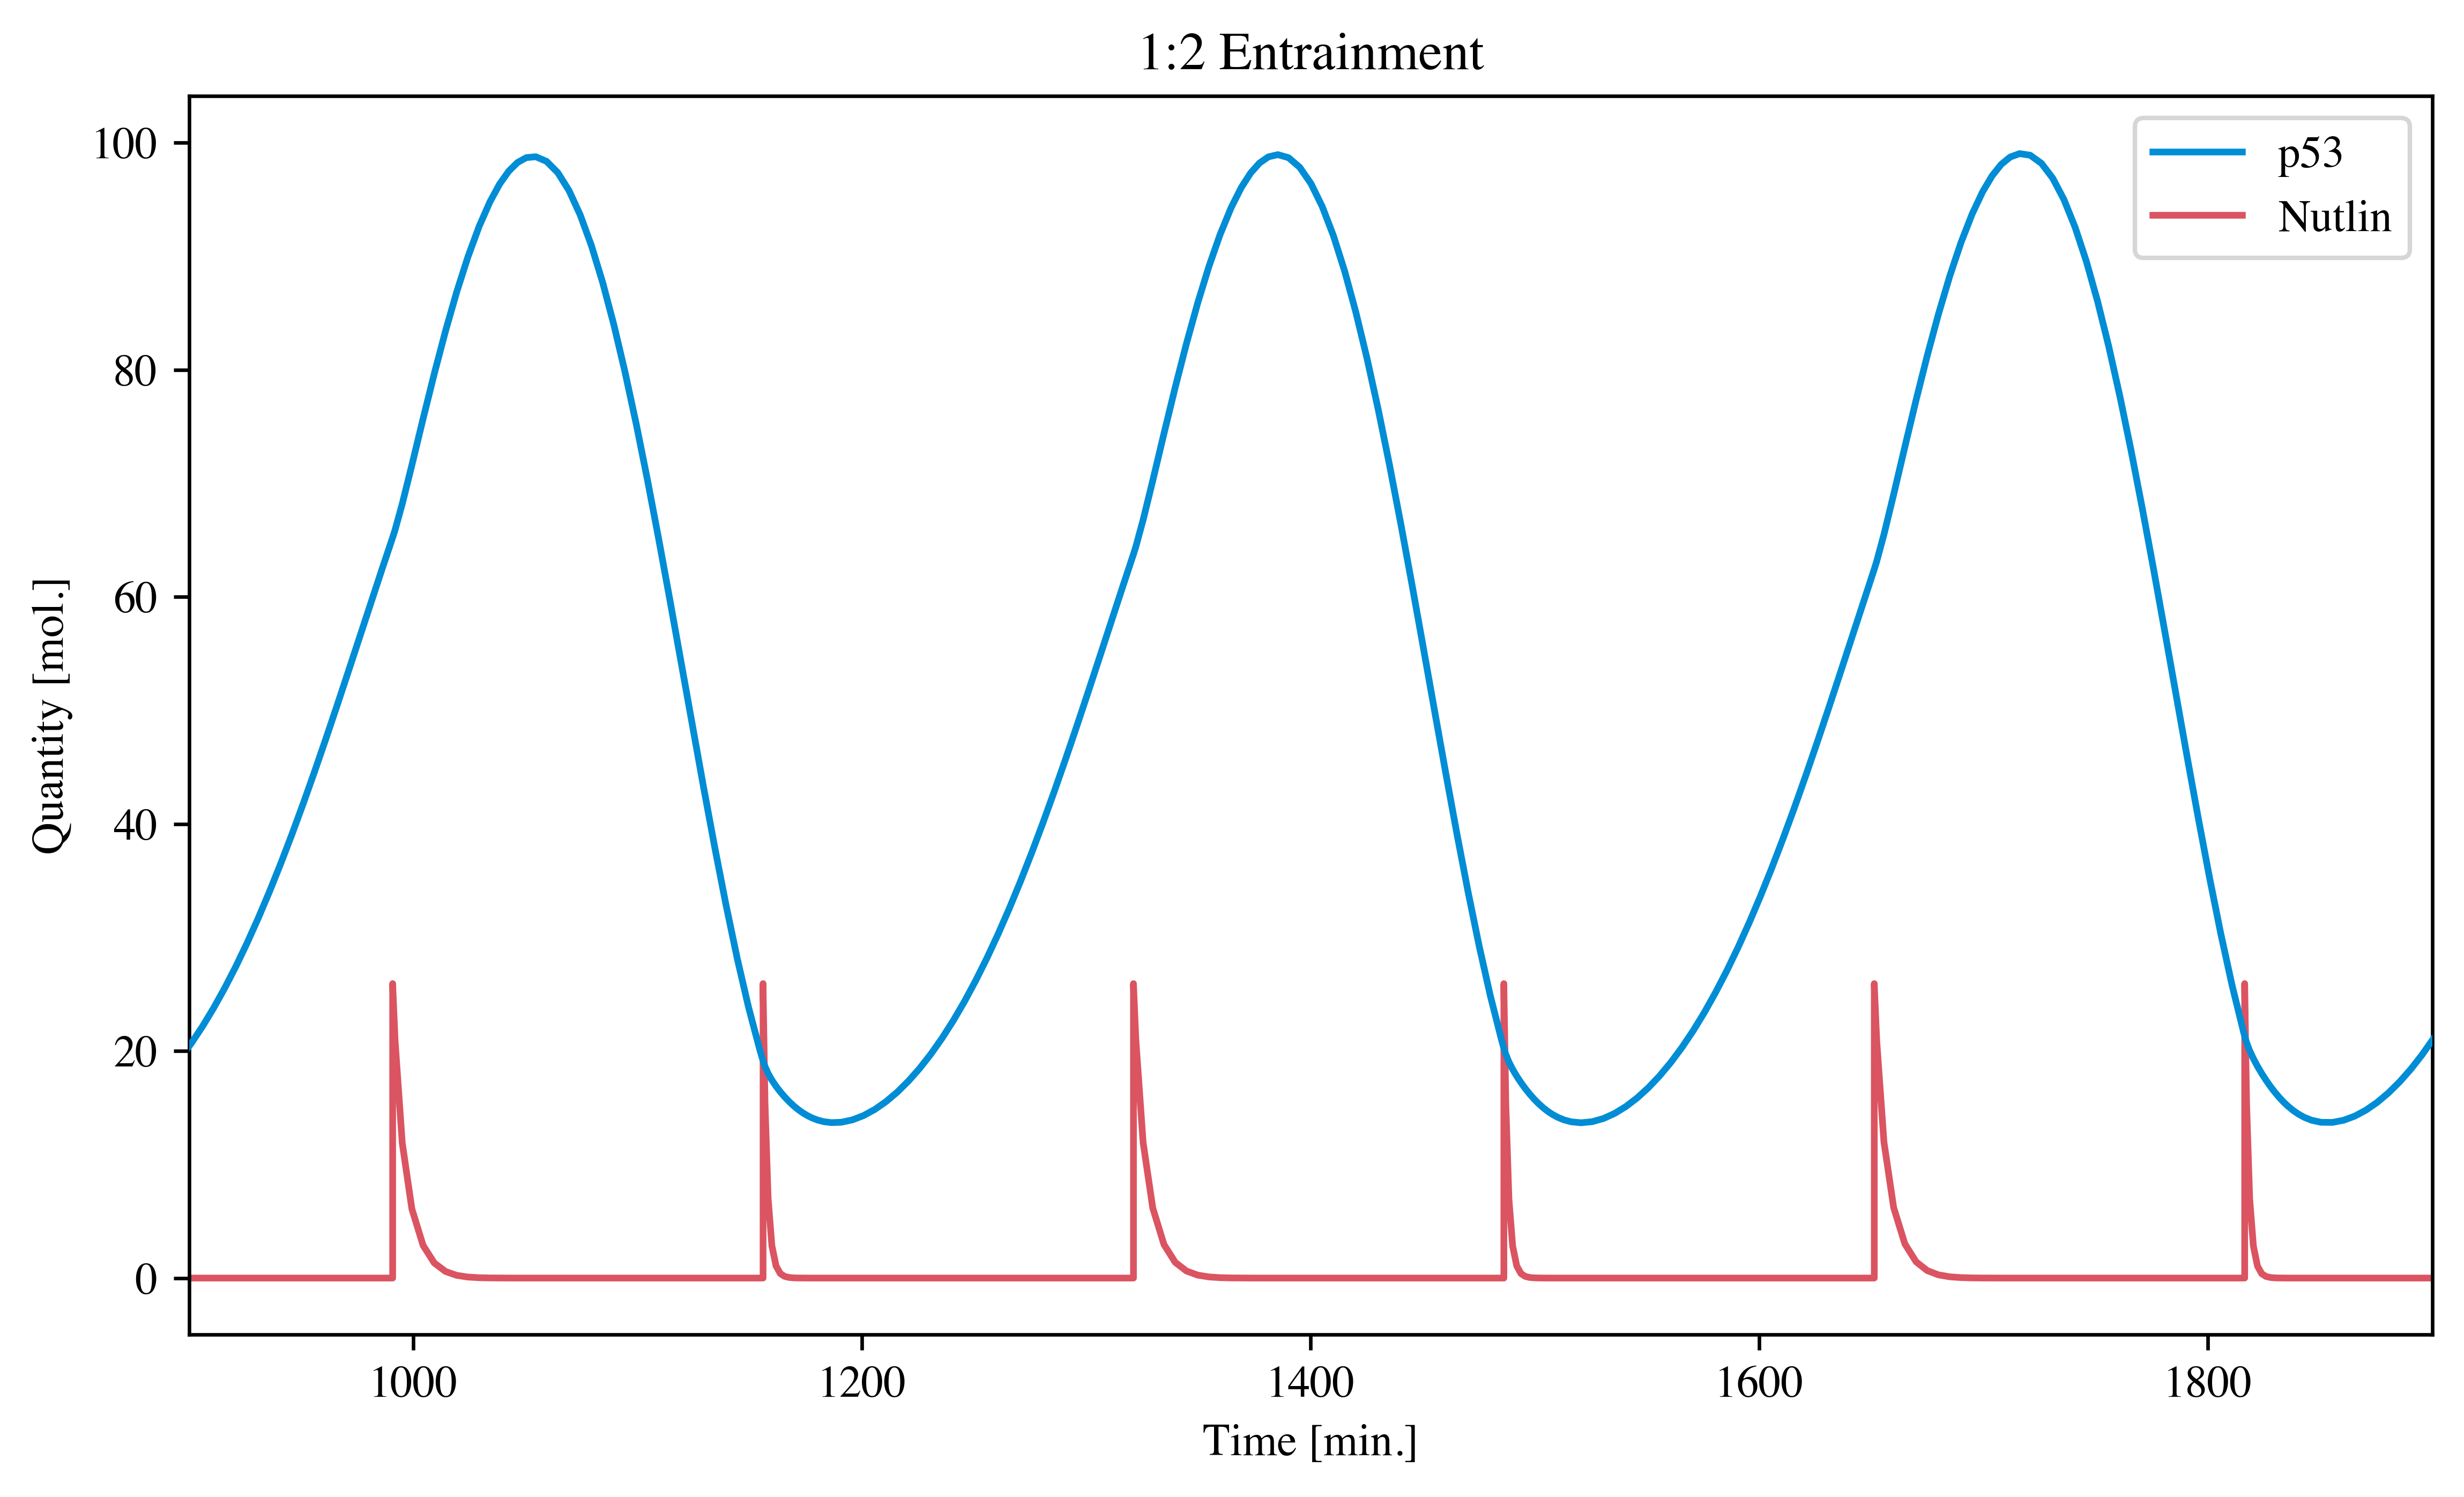

In [26]:
plt.figure(dpi=600, figsize=(9, 5))

plt.plot(t_1, p_1, zorder=10, color = "#008DD5", label="p53")
plt.plot(t_1, n_1, alpha=1, color = "#DB5461", label="Nutlin")
plt.xlim(900, 1900)
plt.title("1:2 Entrainment")
plt.xlabel("Time [min.]")
plt.ylabel("Quantity [mol.]")

plt.legend()
plt.plot()

In [ ]:
def classify_entrianment(y_int, y_ext, current_tongue):
    window = 500
    # Apply a small window and require peak higher than mean
    peaks_internal = len(find_peaks(y_int[window:], height=np.mean(y_int))[0])
    peaks_external = len(find_peaks(y_ext[window:], height=np.mean(y_ext))[0])
    
    # 1/Omega because we are using frequency, which is 1/T
    Omega_ratio = peaks_internal/peaks_external

    print(Omega_ratio)

    rounded_ratio = np.round(Omega_ratio, 4)
    
    print(rounded_ratio)
    print(current_tongue - 1e-2, rounded_ratio, current_tongue + 1e-2)

    # Arbritrary threshold, we hope it works
    if current_tongue - 1e-2 <= rounded_ratio <= current_tongue + 1e-2:
        return True
    else:
        return False


In [ ]:
Omega = classify_entrianment(p_1, n_1, 0.5)
print(Omega)

1.0025445292620865
1.0025
0.49 1.0025 0.51
False
